## Pad pack sequences for Pytorch batch processing with DataLoader

Pytorch setup for batch sentence/sequence processing - minimal working example. The pipeline consists of the following:

1. Convert sentences to ix
2. `pad_sequence` to convert variable length sequence to same size (using dataloader)
3. Convert padded sequences to embeddings
4. `pack_padded_sequence` before feeding into RNN
5. `pad_packed_sequence` on our packed RNN output
6. Eval/reconstruct actual output

当采用 RNN 训练序列样本数据时，会面临序列样本数据长短不一的情况。比如做 NLP 任务、语音处理任务时，每个句子或语音序列的长度经常是不相同。难道要一个序列一个序列的喂给网络进行训练吗？这显然是行不通的。

为了更高效的进行 batch 处理，就需要对样本序列进行填充，保证各个样本长度相同，在 PyTorch 里面使用函数 pad_sequence 对序列进行填充。填充之后的样本序列，虽然长度相同了，但是序列里面可能填充了很多无效值 0 ，将填充值 0 喂给 RNN 进行 forward 计算，不仅浪费计算资源，最后得到的值可能还会存在误差。因此在将序列送给 RNN 进行处理之前，需要采用 pack_padded_sequence 进行压缩，压缩掉无效的填充值。序列经过 RNN 处理之后的输出仍然是压紧的序列，需要采用 pad_packed_sequence 把压紧的序列再填充回来，便于进行后续的处理。

### 1. Convert sentences to ix
Construct word-to-index and index-to-word dictionaries, tokenize words and convert words to indexes. Note the special indexes that we need to reserve for `<pad>, EOS, <unk>, N (digits)`. The indexes should correspond to the position of the word-embedding matrix.

### 2.pad_sequence

**参数**

* sequences:表示输入样本序列，为list类型，list中的元素为tensor类型。tensor的size为L\* F。其中，L为单个序列的长度，F为序列中每个时间步(time step)特征的个数，根据任务的不同F的维度会有所不同。

* batch_first:为True对应[batch_size, seq_len, feature];False对应[seq_len, batch_size, feature],从习惯上来将一般设置为True.

* padding_value:默认为0，填充值

#### 说明

主要用来对样本进行填充，填充值一般为 0 。我们在训练网络时，一般会采用一个一个 mini-batch 的方式，将训练样本数据喂给网络。在 PyTorch 里面数据都是以 tensor 的形式存在，一个 mini-batch 实际上就是一个高维的 tensor ，每个序列数据的长度必须相同才能组成一个 tensor 。为了使网络可以处理 mini-batch 形式的数据，就必须对序列样本进行填充，保证一个 mini-batch 里面的数据长度是相同的。

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pack_sequence, pad_packed_sequence

class MyData(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
def collate_fn(data):
    data.sort(key=lambda x: len(x), reverse=True)
    data = pad_sequence(data, batch_first=True, padding_value=0)
    return data

a = torch.tensor([1,2,3,4])
b = torch.tensor([5,6,7])
c = torch.tensor([7,8])
d = torch.tensor([9])
train_x = [a, b, c, d]

In [2]:
train_x

[tensor([1, 2, 3, 4]), tensor([5, 6, 7]), tensor([7, 8]), tensor([9])]

In [3]:
train_x = pad_sequence(train_x)
train_x

tensor([[1, 5, 7, 9],
        [2, 6, 8, 0],
        [3, 7, 0, 0],
        [4, 0, 0, 0]])

In [4]:
pack_sequence(train_x)   #pack一个经过pad的sequence

PackedSequence(data=tensor([1, 2, 3, 4, 5, 6, 7, 0, 7, 8, 0, 0, 9, 0, 0, 0]), batch_sizes=tensor([4, 4, 4, 4]), sorted_indices=None, unsorted_indices=None)

In [5]:
data = MyData(train_x)
data

In [6]:
data_loader = DataLoader(data, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [7]:
data_loader

In [12]:
batch_x = iter(data_loader).next()

In [13]:
batch_x

tensor([[2, 6, 8, 0],
        [4, 0, 0, 0]])

### 二.pack_padded_sequence

**参数**

* input：经过 pad_sequence 处理之后的数据。

* lengths：mini-batch中各个序列的实际长度。

* batch_first：True 对应[batch_size, seq_len, feature];False对应[seq_len, batch_size, feature] 。

* enforce_sorted：如果是 True ，则输入应该是按长度降序排序的序列。如果是 False ，会在函数内部进行排序。默认值为 True

#### 说明

pack意为压缩，因为数据在经过填充之后，会有很多冗余的padding_value,所以需要压缩一下。

为什么要使用这个函数呢？

RNN 读取数据的方式：网络每次吃进去一组同样时间步 （time step） 的数据，也就是 mini-batch 的所有样本中下标相同的数据，然后获得一个 mini-batch 的输出；再移到下一个时间步 （time step），再读入 mini-batch 中所有该时间步的数据，再输出；直到处理完所有的时间步数据。

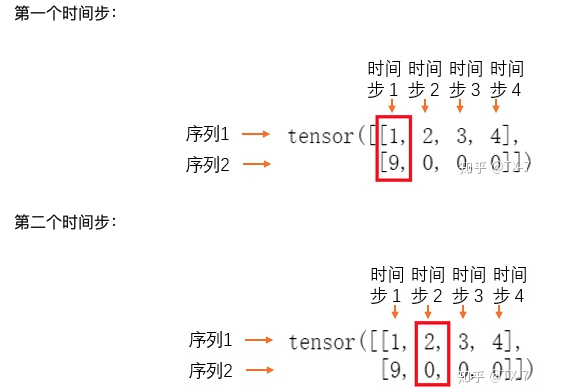

从 batch_x 的值可以看出，第二行填充了一个 0 ，使其长度和第一行保持一致。

需要说明的是，对于长度不同的序列，使用默认的 collate_fn 函数，不自定义 collate_fn 函数完成对序列的填充，上面的程序就会报错。

mini-batch 中的 0 只是用来做数据对齐的 padding_value ，如果进行 forward 计算时，把 padding_value 也考虑进去，可能会导致RNN通过了非常多无用的 padding_value，这样不仅浪费计算资源，最后得到的值可能还会存在误差。对于上面的序列 2 的数据，通过 RNN 网络：

实际上从第 2 个时间步开始一直到最后的计算都是多余的，输入都是无效的 padding_value 而已。    
从上面的分析可以看出，为了使 RNN 可以高效的读取数据进行训练，就需要在 pad 之后再使用 pack_padded_sequence 对数据进行处理。    
需要注意的是，默认条件下，我们必须把输入数据按照序列长度从大到小排列后才能送入 pack_padded_sequence ，否则会报错。

In [20]:
def collate_fn(data):
    data.sort(key=lambda x: len(x), reverse=True)
    seq_len = [s.size(0) for s in data]  #获取数据真正长度
    data = pad_sequence(data, batch_first=True)
    data = pack_padded_sequence(data, seq_len, batch_first=True)
    return data

In [21]:
data

In [22]:
train_x

tensor([[1, 5, 7, 9],
        [2, 6, 8, 0],
        [3, 7, 0, 0],
        [4, 0, 0, 0]])

In [23]:
data_loader = DataLoader(data, batch_size=2, shuffle=True, collate_fn=collate_fn)
batch_x = iter(data_loader).next()

In [24]:
batch_x

PackedSequence(data=tensor([3, 1, 7, 5, 0, 7, 0, 9]), batch_sizes=tensor([2, 2, 2, 2]), sorted_indices=None, unsorted_indices=None)

可以看出，输出返回一个 PackedSequence 对象，它主要包含两部分：data 和 batch_sizes 。

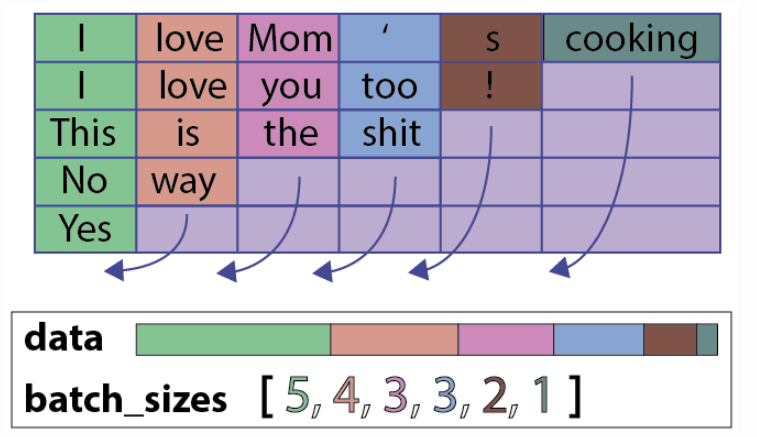

### 三.pack_sequence

**参数**

* sequences：输入样本序列，为 list 类型，list 中的元素为 tensor ；tensor 的 size 为 L * F，其中，L 为单个序列的长度，F 为序列中每个时间步（time step）特征的个数，根据任务的不同 F 的维度会有所不同。

* enforce_sorted：如果是 True ，则输入应该是按长度降序排序的序列。如果是 False ，会在函数内部进行排序。默认值为 True 。

#### 说明

源码:
```
def pack_sequence(sequences, enforce_sorted=True): 
    lengths = torch.as_tensor([v.size(0) for v in sequences]) 
    return pack_padded_sequence(pad_sequence(sequences),lengths,enforce_sorted=enforce_sorted)
```
可以看出**pack_sequence实际上是对pad_sequence和pack_padded_sequence操作的一个封装。通过一个函数完成了两步才能完成的工作。**

对前面collate_fn函数进一步修改：

In [25]:
def collate_fn(data):
    data.sort(key=lambda x: len(x), reverse=True)
   
    data = pack_sequence(data)
    #seq_len = [s.size(0) for s in data]
    #data = pad_sequence(data, batch_first=True)    
    #data = pack_padded_sequence(data, seq_len, batch_first=True)
    return data

In [26]:
data_loader = DataLoader(data, batch_size=2, shuffle=True, collate_fn=collate_fn)
batch_x = iter(data_loader).next()
batch_x   

PackedSequence(data=tensor([4, 3, 0, 7, 0, 0, 0, 0]), batch_sizes=tensor([2, 2, 2, 2]), sorted_indices=None, unsorted_indices=None)

结果与之前的相同。

### 四.pad_packed_sequence

**参数**

* sequences：PackedSequence 对象，将要被填充的 batch ；

* batch_first：一般设置为 True，返回的数据格式为 [batch_size, seq_len, feature] ；

* padding_value：填充值；

* total_length：如果不是None，输出将被填充到长度：total_length。

#### 说明

如果在喂给网络数据的时候，用了 pack_sequence 进行打包，pytorch 的 RNN 也会把输出 out 打包成一个 PackedSequence 对象。这个函数实际上是 pack_padded_sequence 函数的逆向操作。就是把压紧的序列再填充回来。

为啥要填充回来呢？我的理解是，在 collate_fn 函数里面通常也会调用 pad_sequence 对 label 进行填充，RNN 的输出结果为了和 label 对齐，需要将压紧的序列再填充回来，方便后续的计算。

示例   
需要说明的是，下面的程序中，为了产生符合 LSTM 输入格式 [batch_size, seq_len, feature] 的数据，使用了函数 unsqueeze 进行升维处理。其中， batch_size 是样本数，seq_len 是序列长度，feature 是特征数。

In [65]:
class MyData(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
a = torch.tensor([1,2,3,4])
b = torch.tensor([5,6,7])
c = torch.tensor([7,8])
d = torch.tensor([9])
train_x = [a, b, c, d]

data = MyData(train_x)

In [66]:
def collate_fn(data):
    data.sort(key=lambda x: len(x), reverse=True)
    seq_len = [s.size(0) for s in data]
    data = pad_sequence(data, batch_first=True).float()    
    data = data.unsqueeze(-1)
    data = pack_padded_sequence(data, seq_len, batch_first=True)
    return data

In [73]:
data_loader = DataLoader(data, batch_size=2, shuffle=True, collate_fn=collate_fn)
batch_x = iter(data_loader).next()

In [74]:
batch_x

PackedSequence(data=tensor([[1.],
        [9.],
        [2.],
        [3.],
        [4.]]), batch_sizes=tensor([2, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [75]:
rnn = torch.nn.LSTM(1, 4, 1, batch_first=True)

In [76]:
h0 = torch.rand(1, 2, 4).float()
c0 = torch.rand(1, 2, 4).float()

In [77]:
h0

tensor([[[0.9073, 0.3959, 0.1913, 0.9459],
         [0.5832, 0.8836, 0.5773, 0.3913]]])

In [78]:
c0

tensor([[[0.1577, 0.5008, 0.9895, 0.7425],
         [0.6163, 0.8607, 0.0157, 0.5477]]])

In [79]:
out, (h1, c1) = rnn(batch_x, (h0, c0))

In [80]:
out

PackedSequence(data=tensor([[ 0.0876, -0.0113,  0.0067,  0.0577],
        [-0.0080,  0.1152,  0.0017,  0.0257],
        [ 0.1137, -0.1594, -0.0264,  0.0223],
        [ 0.0798, -0.2287, -0.0157,  0.0390],
        [ 0.0409, -0.2598, -0.0038,  0.0650]], grad_fn=<CatBackward>), batch_sizes=tensor([2, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

对 out 调用 pad_packed_sequence 进行填充：

In [81]:
out_pad, out_len = pad_packed_sequence(out, batch_first=True)

In [82]:
out_pad

tensor([[[ 0.0876, -0.0113,  0.0067,  0.0577],
         [ 0.1137, -0.1594, -0.0264,  0.0223],
         [ 0.0798, -0.2287, -0.0157,  0.0390],
         [ 0.0409, -0.2598, -0.0038,  0.0650]],

        [[-0.0080,  0.1152,  0.0017,  0.0257],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]], grad_fn=<TransposeBackward0>)

In [83]:
out_len

tensor([4, 1])

再回想下我们调用 pad_sequence 填充之后的输入：

```
tensor([[1, 2, 3, 4],
        [9, 0, 0, 0]])
```
这个 out_pad 结果其实就和我们填充之后的输入对应起来了。